### Importing necessary libraries

In [2]:
import tensorflow.keras as K
import keras
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

### Importing and analyzing breast cancer images

In [3]:
# load images of shape (5547, 50, 50, 3)
x_images = np.load('X.npy')  

# load labels of shape (5547,1); (0 = no cancer, 1 = cancer)
y_images = np.load('Y.npy')   

# shuffle data
perm_array = np.arange(len(x_images))
np.random.shuffle(perm_array)
x_images = x_images[perm_array]
y_images = y_images[perm_array]

print('x_images.shape =', x_images.shape)
print('x_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images.min(),
                        x_images.mean(), x_images.std(), x_images.max()))
print('')
print('y_images.shape =', y_images.shape)
print('y_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_images.min(),
                        y_images.mean(), y_images.std(), y_images.max()))

x_images.shape = (5547, 50, 50, 3)
x_images.min/mean/std/max = 2.00/185.03/47.25/255.00

y_images.shape = (5547,)
y_images.min/mean/std/max = 0.00/0.50/0.50/1.00


#### Printing 30 images along with their IDC value

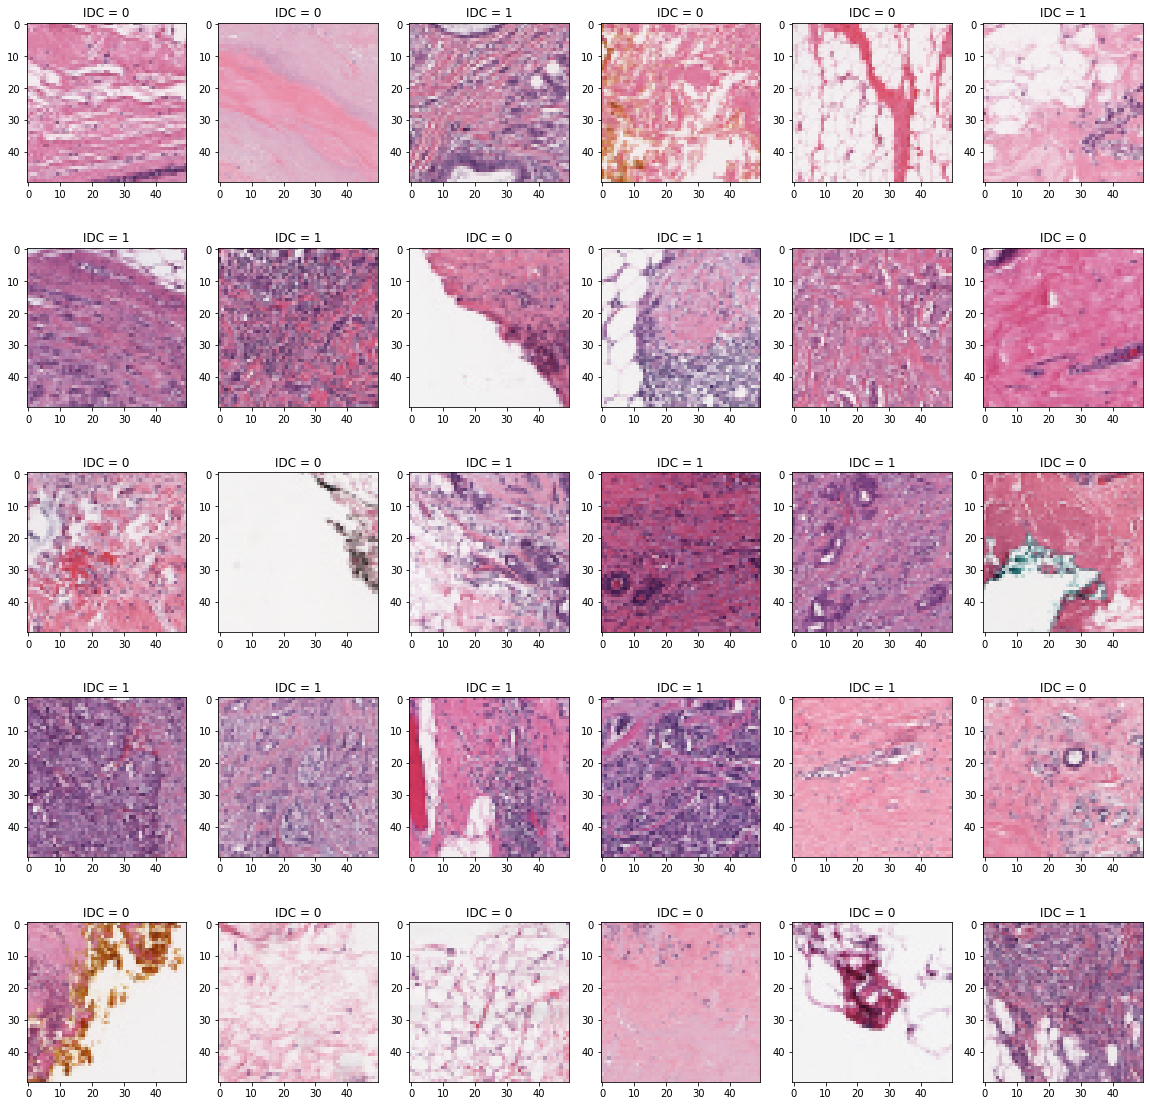

In [4]:
imgs_0 = x_images[y_images == 0] # 0 = no cancer
imgs_1 = x_images[y_images == 1] # 1 = cancer

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%y_images[i])
    plt.imshow(x_images[i])

#### Plotting histograms of RGB values for image with breast cancer and without breast cancer

red channel: min/mean/std/max = 4.00/205.79/36.29/255.00
green channel: min/mean/std/max = 2.00/161.87/53.94/255.00
blue channel: min/mean/std/max = 5.00/187.44/38.69/255.00


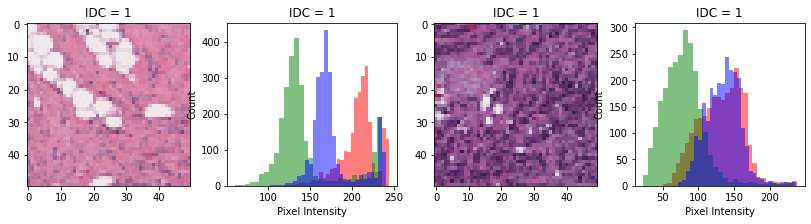

In [5]:
plt.figure(figsize=(14,3))

for i in range(2):
    n_img = np.random.randint(len(x_images))
    plt.subplot(1,4,1+2*i)
    plt.title('IDC = %d'%y_images[n_img])
    plt.imshow(x_images[n_img])
    plt.subplot(1,4,2+2*i)
    plt.title('IDC = %d'%y_images[n_img])
    plt.ylabel('Count')
    plt.xlabel('Pixel Intensity')
    plt.hist(x_images[n_img,:,:,0].flatten(), bins=30, lw = 0,color='r', alpha=0.5);
    plt.hist(x_images[n_img,:,:,1].flatten(), bins=30, lw = 0, color='g', alpha=0.5);
    plt.hist(x_images[n_img,:,:,2].flatten(), bins=30, lw = 0, color='b', alpha=0.5);
print('red channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,0].min(),
    x_images[:,:,:,0].mean(), x_images[:,:,:,0].std(), x_images[:,:,:,0].max()))
print('green channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,1].min(),
    x_images[:,:,:,1].mean(), x_images[:,:,:,1].std(), x_images[:,:,:,1].max()))
print('blue channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,2].min(),
    x_images[:,:,:,2].mean(), x_images[:,:,:,2].std(), x_images[:,:,:,2].max()))

In [6]:
x_images.shape

(5547, 50, 50, 3)

In [7]:
y_images.shape

(5547,)

### Preprocessing data

#### Preprocessing the data using ResNet 50 pretrained model from Keras

In [8]:
def preprocess(X,Y):
    # X is a numpy array of shape (n,50,50,3) where n is number of images, 3 represents RGB colours
    # Y is a numpy array of shape (n,1) where n is number of images
    X_p = K.applications.resnet50.preprocess_input(X)
    Y_p = K.utils.to_categorical(Y,2)
    #a,b,c,d = X_p.shape
    #X_p= np.reshape(X_p,(a,d))
    return X_p, Y_p

#### Splitting data into train and test splits in 80:20 ratio and preprocessing them

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x_images, y_images, test_size=0.2, random_state=42)
X_train, y_train = preprocess(X_train, y_train)
X_test, y_test = preprocess(X_test, y_test)

### Building and training the model

#### Importing the pretrained ResNet50 model to use pretrained weights

In [10]:
input_t = K.Input(shape = (224,224,3))
res_model = K.applications.ResNet50(include_top = False, weights = "imagenet", input_tensor = input_t)

#### We make all layers except the last one untrainable so as to fix them and reduce computation cost

In [11]:
for layer in res_model.layers[:143]:
        layer.trainable = False

#### Adding ResNet-50 model to Keras Sequential Layers and adding more Layers

In [12]:
to_res = (224, 224)
model = K.models.Sequential()
model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res))) 
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(256, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(64, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(2, activation='softmax'))

#### Training the model and storing the model with best val_accuracy

In [13]:
check_point = K.callbacks.ModelCheckpoint(filepath="XAI.healthcare.model",
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )
model.compile(loss='categorical_crossentropy',
                  optimizer=K.optimizers.RMSprop(lr=2e-3),
                  metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=16, epochs=12, verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks=[check_point])
model.summary()

Epoch 1/12


c:\users\b51gh\appdata\local\programs\python\python39\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


278/278 [==============================] - 507s 2s/step - loss: 0.7309 - accuracy: 0.6329 - val_loss: 4.0150 - val_accuracy: 0.6550
Epoch 2/12
278/278 [==============================] - 499s 2s/step - loss: 0.5380 - accuracy: 0.7532 - val_loss: 0.7993 - val_accuracy: 0.7937
Epoch 3/12
278/278 [==============================] - 476s 2s/step - loss: 0.4791 - accuracy: 0.7850 - val_loss: 0.6537 - val_accuracy: 0.8027
Epoch 4/12
278/278 [==============================] - 481s 2s/step - loss: 0.4388 - accuracy: 0.8118 - val_loss: 4.0203 - val_accuracy: 0.7090
Epoch 5/12
278/278 [==============================] - 479s 2s/step - loss: 0.3833 - accuracy: 0.8382 - val_loss: 0.7315 - val_accuracy: 0.8063
Epoch 6/12
278/278 [==============================] - 495s 2s/step - loss: 0.3306 - accuracy: 0.8702 - val_loss: 0.7695 - val_accuracy: 0.7793
Epoch 7/12
278/278 [==============================] - 495s 2s/step - loss: 0.2908 - accuracy: 0.8891 - val_loss: 0.6309 - val_accuracy: 0.8144
Epoch 8/12

#### Showing the progression of val_accuracy, val_loss, accuracy and loss with respect to each epoch

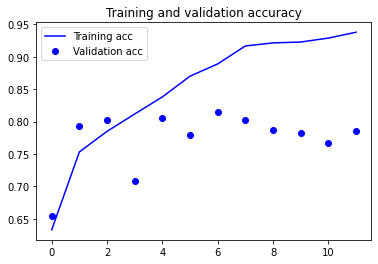

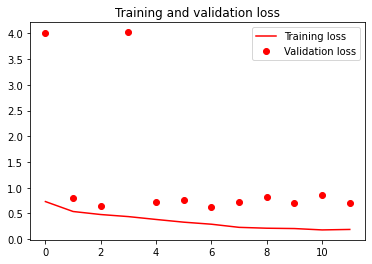

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
history.history

{'loss': [0.7309304475784302,
  0.5379965305328369,
  0.47905319929122925,
  0.438782662153244,
  0.3833008408546448,
  0.33061960339546204,
  0.29083797335624695,
  0.23001855611801147,
  0.2132483720779419,
  0.2066219002008438,
  0.180197075009346,
  0.1893705278635025],
 'accuracy': [0.6328600645065308,
  0.7532116174697876,
  0.7849898338317871,
  0.811809778213501,
  0.8381789326667786,
  0.8701825737953186,
  0.889114260673523,
  0.9168357253074646,
  0.9215686321258545,
  0.9229208827018738,
  0.9290060997009277,
  0.938021183013916],
 'val_loss': [4.015011787414551,
  0.7993014454841614,
  0.6537498235702515,
  4.0202555656433105,
  0.7314899563789368,
  0.7695336937904358,
  0.6309418678283691,
  0.7191161513328552,
  0.8224158883094788,
  0.6977998614311218,
  0.8531767725944519,
  0.7000932097434998],
 'val_accuracy': [0.6549549698829651,
  0.7936937212944031,
  0.8027027249336243,
  0.7090089917182922,
  0.8063063025474548,
  0.7792792916297913,
  0.8144144415855408,
  0.8

#### Displaying the final accuracies

In [15]:
print("Validation Accuracy: ",max(history.history['val_accuracy']))
print("Training Accuracy: ",max(history.history['accuracy']))

Validation Accuracy:  0.8144144415855408
Training Accuracy:  0.938021183013916


#### Making prediction on the test dataset

In [16]:
y_pred = model.predict(X_test)

35/35 [==============================] - 121s 3s/step


#### Making a list containing the final predictions for X_test

In [17]:
y_classes = [np.argmax(y, axis=None, out=None) for y in y_pred]

#### Displaying images with and without cancer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

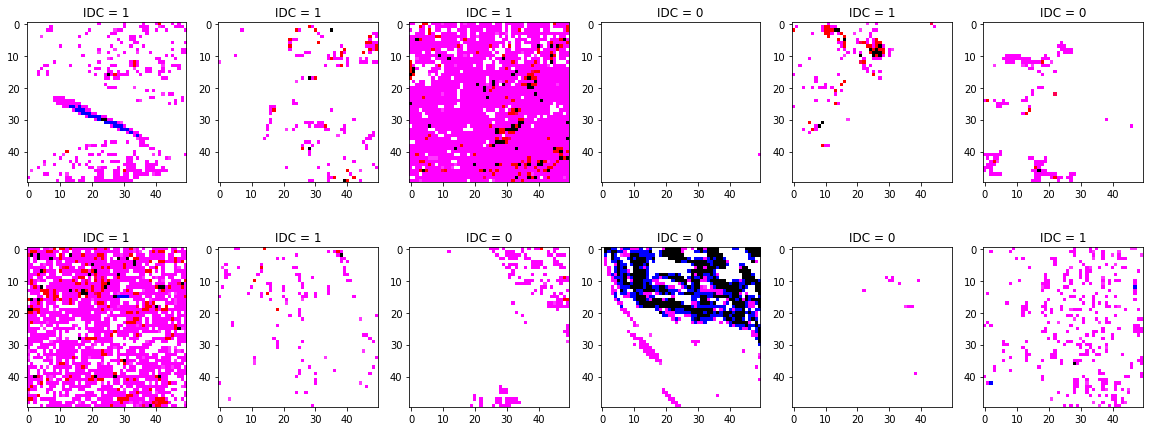

In [18]:
imgs_0 = X_test[y_classes == 0] # 0 = no cancer
imgs_1 = X_test[y_classes == 1] # 1 = cancer

plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%y_classes[i])
    plt.imshow(X_test[i])

### Post-hoc explanation

#### Importing and created LIME image explainer

In [19]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [30]:
explanation = explainer.explain_instance(X_test[100].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


#### Visualizing the LIME explaination using scikit-learn's segmenation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 49.5, 49.5, -0.5)

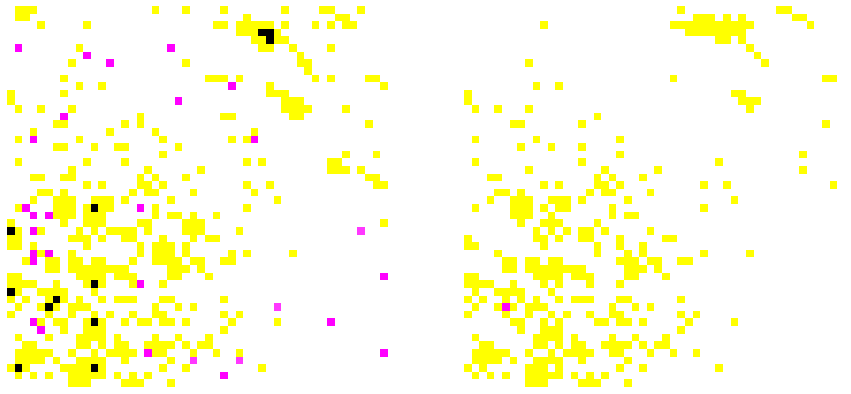

In [34]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

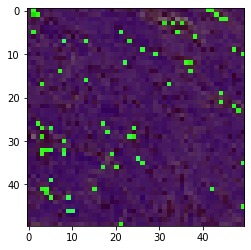

In [31]:
plt.imshow(X_test[100].astype('uint8'))

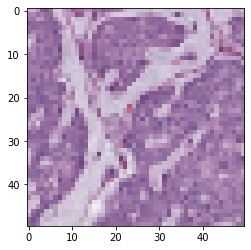

In [32]:
plt.imshow(x_images[100].astype('uint8'))

#### Visualizing the LIME explanation using heatmap

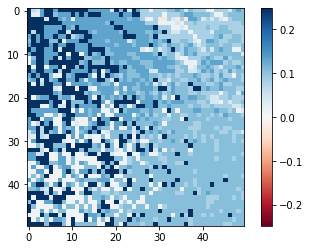

In [33]:
ind =  explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()